## This notebook has the goal of providing a clear motivation for using a Mixture of Factor Analyzers over a PCA model

It will implement the following tests:
1. The Reconstruction vs. Compression Trade-off (The Math Test)
2. The Spectral Library Match (The Physics Test)
3. The Latent Factor Interpretability (The Science Test)
4. The Outlier Rejection Threshold (The Streaming Prerequisite)


In [1]:
import torch
import glob
import matplotlib.pyplot as plt
from MFA import MFA
from utils import get_data, reconstruct_mfa, calculate_rmse, calculate_sam
from enum import Enum
import matplotlib.pyplot as plt
from hypso import Hypso
import numpy as np
import os

These are the setup variables for the model:

In [2]:
class DataProduct(Enum):
    L1A = 'l1a'
    L1B = 'l1b'
    L1D = 'l1d'

In [3]:
data_product = DataProduct.L1B
K = 8 # Number of MFA compobnents to use 
q = 5 # Latent dimensionality for MFA
Train_PCA_on_L1Normalized = False
Train_MFA_on_L1Normalized = True

In [4]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

data_dir = glob.glob(f'data/training_{data_product.value}/*.nc')
print(f"Found {len(data_dir)} files.")

Using device: cpu
Found 44 files.


In [5]:
target_total_samples = 200000

data_list = get_data(data_dir, data_product.value, target_total_samples)

data = torch.from_numpy(data_list).float().to(device)

Aiming to extract ~4545 pixels per file from 44 files to reach a total of ~200000 samples.
1/44 | File: data/training_l1b\aeronetgalata_2025-01-02T08-18-16Z-l1b.nc | Extracted 4545 pixels.
2/44 | File: data/training_l1b\algeria_2022-10-29T09-44-03Z-l1b.nc | Extracted 4545 pixels.
3/44 | File: data/training_l1b\amazonia_2024-09-21T13-12-47Z-l1b.nc | Extracted 4545 pixels.
4/44 | File: data/training_l1b\annapolis_2025-08-04T15-25-40Z-l1b.nc | Extracted 4545 pixels.
5/44 | File: data/training_l1b\antarctica_2022-11-20T08-44-35Z-l1b.nc | Extracted 4545 pixels.
6/44 | File: data/training_l1b\barfire_2025-08-04T09-11-36Z-l1b.nc | Extracted 4545 pixels.
7/44 | File: data/training_l1b\bermuda_2024-07-16T14-27-21Z-l1b.nc | Extracted 4545 pixels.
8/44 | File: data/training_l1b\blacksea2_2024-07-21T07-40-44Z-l1b.nc | Extracted 4545 pixels.
9/44 | File: data/training_l1b\capedyer_2023-10-16T14-54-55Z-l1b.nc | Extracted 4545 pixels.
10/44 | File: data/training_l1b\capescott_2023-05-09T19-29-59Z-l1b

## Look for outliers or dead pixels

Iterating over the pixels to see if any are all zero or all max

In [6]:
# We check if ALL values along the last dimension (bands) are 0
dead_pixel_mask = (data == 0).all(dim=-1)

# Get the indices/coordinates of the dead pixels
dead_pixel_indices = torch.nonzero(dead_pixel_mask)

# Check how many dead pixels were found
print(f"Number of dead pixels: {dead_pixel_indices.shape[0]}")

Number of dead pixels: 0


## Model training

#### Training an MFA

In [7]:
if Train_MFA_on_L1Normalized:
    print("Applying L2 Normalization to data")
    norms = torch.norm(data, p=2, dim=1, keepdim=True)
    epsilon = 1e-8
    X = data / (norms + epsilon)
else: 
    print("Using raw data without normalization")
    X = data
# Ensure float32
X = X.float()
print(f"Shape of X: {X.shape}")

mfa_model = MFA(n_components=K, n_features=X.shape[1], n_factors=q, device=device)

mfa_model.initialize_parameters(X)
# Fit
mfa_model.fit(X)
# Clean up memory if using GPU
if device.type == 'cuda':
    torch.cuda.empty_cache()
# Save model
mfa_state = {
    # model.state_dict() automatically grabs log_pi, mu, Lambda, log_psi
    'model_state_dict': mfa_model.state_dict(), 
    # Hyperparameters (Required to re-initialize the class) --
    'hyperparameters': {
        'n_components': K,
        'n_features': X.shape[1],
        'n_factors': q
    },
}
save_path = f'models/final_test/mfa_k{K}_q{q}.pt'
torch.save(mfa_state, save_path)
print(f"MFA model saved to '{save_path}'")

Applying L2 Normalization to data
Shape of X: torch.Size([199980, 120])


MFA model saved to 'models/final_test/mfa_k8_q5.pt'


#### Training PCA

Training PCA on original data (not L1-Normalized)
------------------------------
Cumulative Variance for top 10 components:
 tensor([0.9005, 0.9596, 0.9839, 0.9936, 0.9954, 0.9971, 0.9981, 0.9986, 0.9990,
        0.9993])
------------------------------
Number of components to explain 99.5% variance: 5
Ceiling for q (latent factors) set to: 5
PCA model saved to 'models/pca_benchmark_DataProduct.L1B.pt'


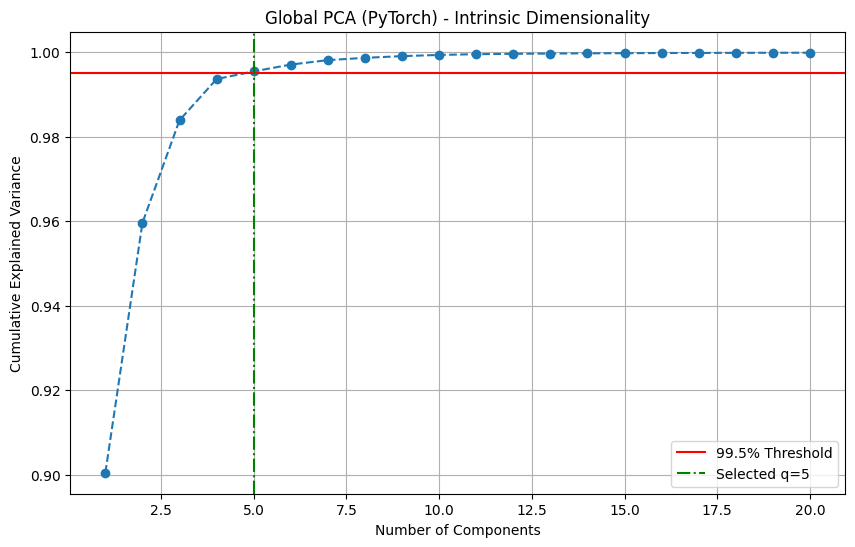

In [8]:
# 1. Mean Centering
if Train_PCA_on_L1Normalized:
    print("Training PCA on L1-Normalized data")
    X_train = X # X is the L1-Normalized data from above
else: 
    print("Training PCA on original data (not L1-Normalized)")
    X_train = data.float() # Use original data for PCA

mean_vector = X_train.mean(dim=0)
X_centered = X_train - mean_vector

# 2. Compute Covariance Matrix
n_samples = X_centered.shape[0]
cov_matrix = (X_centered.T @ X_centered) / (n_samples - 1)

# 3. Eigendecomposition (PCA)
eigenvalues, eigenvectors = torch.linalg.eigh(cov_matrix)

# 4. Sort indices in descending order (eigh returns ascending)
sorted_indices = torch.argsort(eigenvalues, descending=True)
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_components = eigenvectors[:, sorted_indices]

# 5. Calculate Cumulative Variance
total_variance = sorted_eigenvalues.sum()
explained_variance_ratio = sorted_eigenvalues / total_variance
cum_var = torch.cumsum(explained_variance_ratio, dim=0)

# 6. Find the threshold (99.5%)
threshold = 0.995
n_components_995 = (cum_var >= threshold).nonzero(as_tuple=False)[0].item() + 1

print("-" * 30)
print(f"Cumulative Variance for top 10 components:\n {cum_var[:10]}")
print("-" * 30)
print(f"Number of components to explain {threshold*100}% variance: {n_components_995}")
print(f"Ceiling for q (latent factors) set to: {n_components_995}")

# 7. Save the PCA Model
pca_state = {
    'components': sorted_components[:, :n_components_995], # Save only needed components
    'mean': mean_vector,
    'explained_variance': sorted_eigenvalues[:n_components_995],
    'n_components_995': n_components_995
}

torch.save(pca_state, f'models/pca_benchmark_{data_product}.pt')
print(f"PCA model saved to 'models/pca_benchmark_{data_product}.pt'")

# Move to CPU for plotting
cum_var_np = cum_var.cpu().numpy()
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), cum_var_np[:20], marker='o', linestyle='--')
plt.axhline(y=threshold, color='r', linestyle='-', label=f'{threshold*100}% Threshold')
plt.axvline(x=n_components_995, color='g', linestyle='-.', label=f'Selected q={n_components_995}')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Global PCA (PyTorch) - Intrinsic Dimensionality')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
del mean_vector, X_centered, data, X

## Model testing

Model testing consists of 3 main tests

1. **Reconstruction:** The RMSE and SAM is calculated for reconstruction from latent space for both the MFA and the result is compared to the PCA-model

2. **Clasification:** An visual classification test is performed. In this test a colour is given to each factor, and for a given image, each pixel is assinged a Factor. A visual test is performed to see if the creared clusters represents physical materials.

3. **Loadings:** For each loading, *mu* is plotted. The object is to see how *mu* differs for each Factor. If for the factors *mu* has the same shape but diffrent intensity, that is evidense for the model only capturing differnet light intensities and clustering based on those. if *mu* has different shapes, it is evident that the model has learn usefull spectra. Preferably, *mu* should resemble the spectra of vegetation, ocean, cloud, etc.  

In [10]:
test_data_dir = glob.glob(f'data/testing_{data_product.value}/*.nc')
print(f"Found {len(test_data_dir)} files.")

target_total_samples = 15000

test_data_list = get_data(test_data_dir, data_product.value, target_total_samples)

test_data = torch.from_numpy(test_data_list).float().to(device)

Found 14 files.
Aiming to extract ~1071 pixels per file from 14 files to reach a total of ~15000 samples.
1/14 | File: data/testing_l1b\a_mwanza_2022-07-21T07-43-03Z-l1b.nc | Extracted 1071 pixels.
2/14 | File: data/testing_l1b\caspiansea2_2024-07-07T06-58-07Z-l1b.nc | Extracted 1071 pixels.
3/14 | File: data/testing_l1b\durban_2023-06-13T07-33-54Z-l1b.nc | Extracted 1071 pixels.
4/14 | File: data/testing_l1b\falklands_2022-12-02T12-27-07Z-l1b.nc | Extracted 1071 pixels.
5/14 | File: data/testing_l1b\garrylake_2025-02-03T17-29-18Z-l1b.nc | Extracted 1071 pixels.
6/14 | File: data/testing_l1b\gobabeb_2024-03-14T09-14-22Z-l1b.nc | Extracted 1071 pixels.
7/14 | File: data/testing_l1b\gulfofcampeche_2024-05-17T15-49-37Z-l1b.nc | Extracted 1071 pixels.
8/14 | File: data/testing_l1b\jiaozhouBayBridge_2022-11-20T01-55-00Z-l1b.nc | Extracted 1071 pixels.
9/14 | File: data/testing_l1b\lacrau_2025-01-17T09-40-10Z-l1b.nc | Extracted 1071 pixels.
10/14 | File: data/testing_l1b\lakevolta_2023-01-19

#### Reconstruction

In [11]:
with torch.no_grad():
    # Flatten Data to 2D
    X_raw = test_data.clone().detach().to(dtype=torch.float32, device=device)
    # Reshape only if it is 3D
    if X_raw.ndim == 3:
        X_raw = X_raw.reshape(-1, X_raw.shape[-1])
    
    if Train_MFA_on_L1Normalized:
        print("Applying L2 Normalization to data for reconstruction")
        # Apply L2 Normalization to the data
        norms = torch.norm(X_raw, p=2, dim=1, keepdim=True)
        epsilon = 1e-8
        X = X_raw / (norms + epsilon)
    else: 
        print("Using raw data without normalization")
        X = X_raw
    # MFA Benchmarks
    X_rec_mfa_shape, cluster_ids = reconstruct_mfa(mfa_model, X)
    if Train_MFA_on_L1Normalized:
        pixel_norms = torch.linalg.norm(X_raw, dim=1, keepdim=True).clamp(min=1e-8)
        X_rec_mfa_physical = X_rec_mfa_shape * pixel_norms # Restore magnitude
    else: 
        X_rec_mfa_physical = X_rec_mfa_shape # Already in physical space
        
    rmse_mfa = calculate_rmse(X_raw, X_rec_mfa_physical)
    sam_mfa = calculate_sam(X_raw, X_rec_mfa_physical)
    print("=== MFA Reconstruction Benchmark ===")
    print(f"MFA (K={mfa_model.K}, q={mfa_model.q}, RMSE = {rmse_mfa:.4f}, SAM = {sam_mfa:.4f}")
    # Clear variables to free memory for PCA benchmark
    del X_rec_mfa_shape, X_rec_mfa_physical

    # PCA Benchmarks
    if Train_PCA_on_L1Normalized:
        print("Using PCA trained on L1-Normalized data for reconstruction")
        X_train = X # Use the same L1-Normalized data for PCA
    else:
        print("Using PCA trained on original data for reconstruction")
        X_train = test_data.float() # Use original data for PCA

    X_centered = X_train - pca_state['mean']
    components = pca_state['components']
    X_rec_pca_shape = X_centered @ components @ components.T + pca_state['mean']

    if Train_PCA_on_L1Normalized: 
        X_rec_pca_physical = X_rec_pca_shape * pixel_norms # Restore magnitude
    else: 
        X_rec_pca_physical = X_rec_pca_shape # Already in physical space
        
    rmse_pca = calculate_rmse(X_raw, X_rec_pca_physical)
    sam_pca = calculate_sam(X_raw, X_rec_pca_physical)
    print("=== PCA Reconstruction Benchmark ===")
    print(f"PCA (n_components={pca_state['n_components_995']}) RMSE = {rmse_pca:.4f}, SAM = {sam_pca:.4f}")

Applying L2 Normalization to data for reconstruction
=== MFA Reconstruction Benchmark ===
MFA (K=8, q=5, RMSE = 1.2830, SAM = 0.0197
Using PCA trained on original data for reconstruction
=== PCA Reconstruction Benchmark ===
PCA (n_components=5) RMSE = 2.7597, SAM = 0.0507


In [12]:
del X_raw, test_data, test_data_list, X, X_centered, components, X_rec_pca_shape, X_rec_pca_physical, pixel_norms

#### Classification

Using 7 files for testing.
Processing file: data/testing_l1b\a_mwanza_2022-07-21T07-43-03Z-l1b.nc
Image Shape: 956x684 with 120 bands


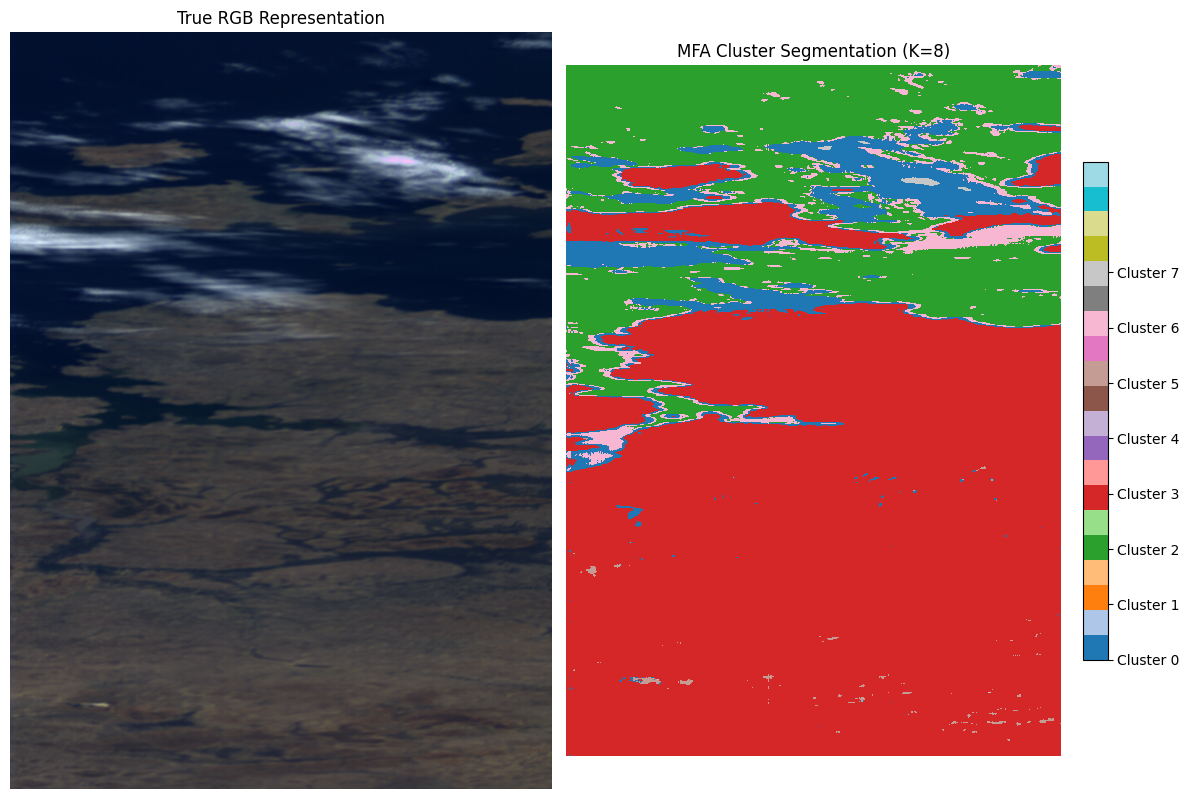

Processing file: data/testing_l1b\caspiansea2_2024-07-07T06-58-07Z-l1b.nc
Image Shape: 598x1092 with 120 bands


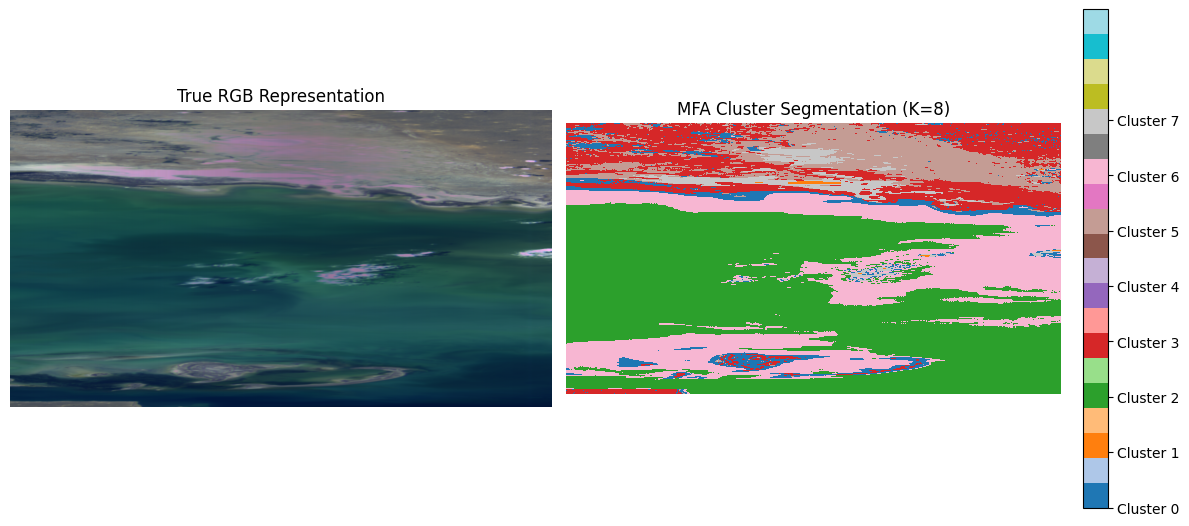

Processing file: data/testing_l1b\durban_2023-06-13T07-33-54Z-l1b.nc
Image Shape: 956x684 with 120 bands


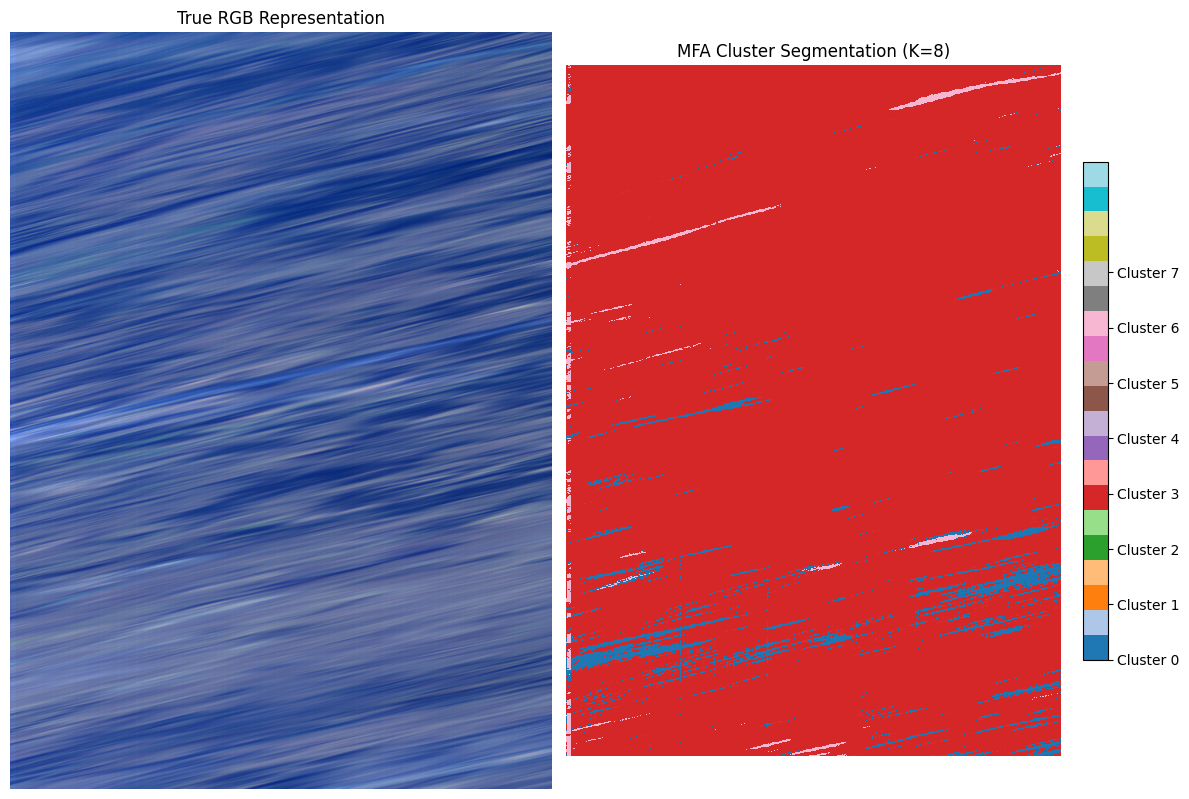

Processing file: data/testing_l1b\falklands_2022-12-02T12-27-07Z-l1b.nc
Image Shape: 956x684 with 120 bands


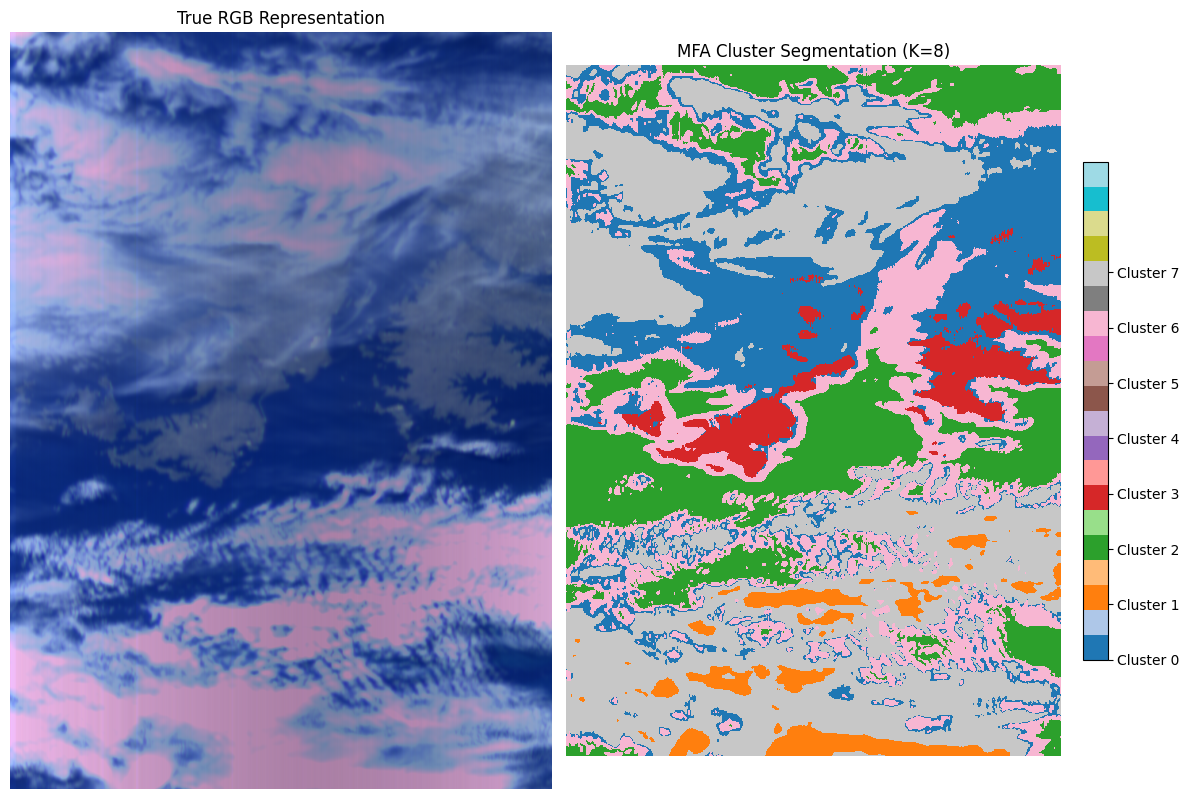

Processing file: data/testing_l1b\garrylake_2025-02-03T17-29-18Z-l1b.nc
Image Shape: 598x1092 with 120 bands


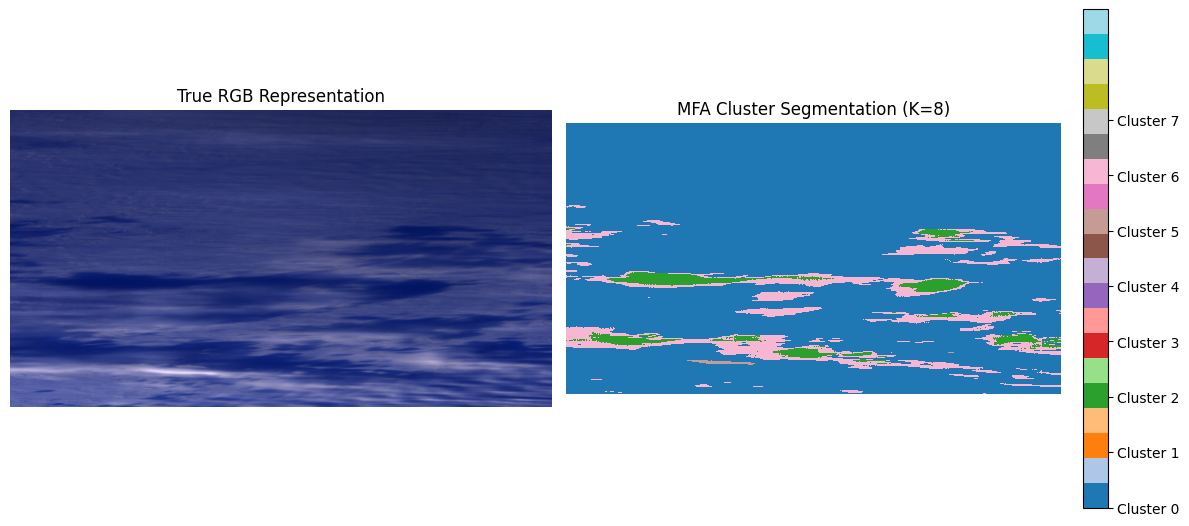

Processing file: data/testing_l1b\gobabeb_2024-03-14T09-14-22Z-l1b.nc
Image Shape: 598x1092 with 120 bands


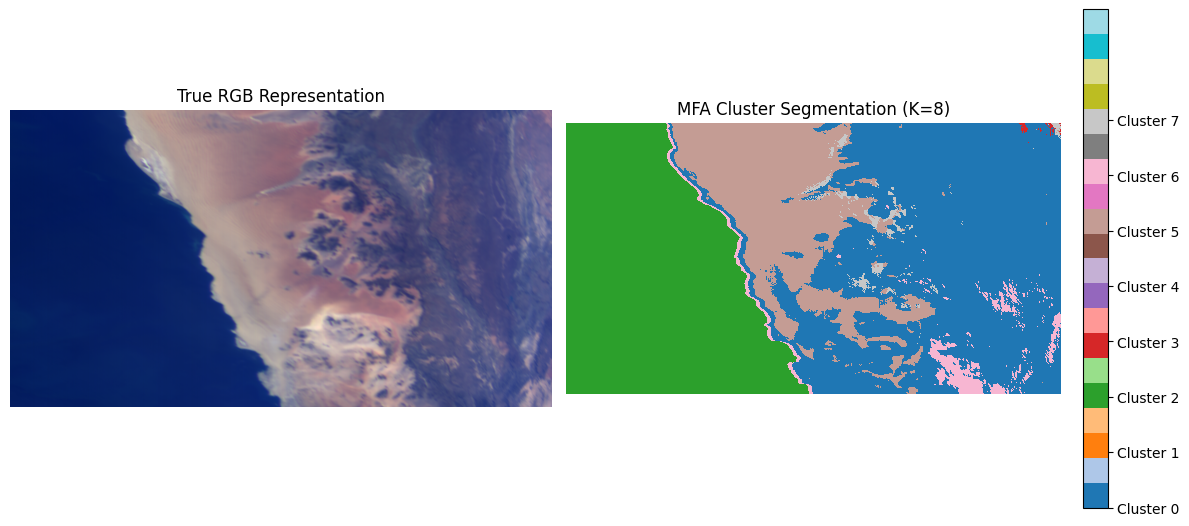

Processing file: data/testing_l1b\gulfofcampeche_2024-05-17T15-49-37Z-l1b.nc
Image Shape: 598x1092 with 120 bands


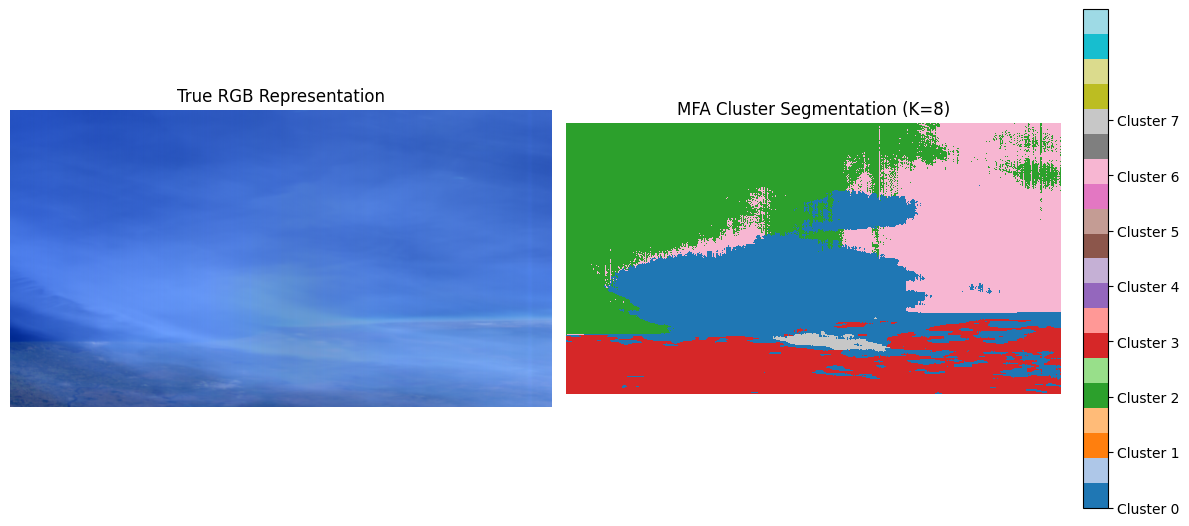

In [13]:
NUM_TEST_FILES = 7

num_test_files = min(NUM_TEST_FILES, len(data_dir))
print(f"Using {num_test_files} files for testing.")

#Fetching files from the testing directory 
for i in range(num_test_files):
    file = test_data_dir[i]
    print(f"Processing file: {file}")

    satobj = Hypso(file) 

    # Load the full image data
    match data_product:
        case DataProduct.L1A:
            image = satobj.l1a_cube.values.astype(np.float32)
        case DataProduct.L1B:
            image = satobj.l1b_cube.values.astype(np.float32)
        case DataProduct.L1D:
            image = satobj.l1d_cube.values.astype(np.float32)
        case _:
            raise ValueError(f"Unknown data product: {data_product}")

    h, w, b = image.shape
    print(f"Image Shape: {h}x{w} with {b} bands")

    # Flatten the full image for the model
    data_2d_full = image.reshape(-1, b) # Shape: (Total_Pixels_In_Image, 120)

    # Preprocess the full image
    # We must use the same stats we used for the random test set
    data_2d_full_tensor = torch.tensor(data_2d_full, dtype=torch.float32).to(device)
    if Train_MFA_on_L1Normalized:
        norms = torch.norm(data_2d_full_tensor, p=2, dim=1, keepdim=True)
        epsilon = 1e-8
        processed_image = (data_2d_full_tensor / (norms + epsilon))
    else:
        processed_image = data_2d_full_tensor
    # Run Inference to get NEW cluster_ids for this specific image
    with torch.no_grad():
        # We only need the responsibilities to get the argmax (cluster id)
        log_resp, _ = mfa_model.e_step(processed_image)
        responsibilities = torch.exp(log_resp)
        new_cluster_ids = torch.argmax(responsibilities, dim=1)

    # reshape the new IDs
    seg_map = new_cluster_ids.reshape(h, w).cpu().numpy()

    # Get RGB for comparison (Bands 70, 50, 20 approx for Hypso)
    rgb_bands = [70, 50, 20]
    rgb_img = image[:, :, rgb_bands]
    # Normalize RGB for display
    rgb_img = (rgb_img - np.min(rgb_img)) / (np.max(rgb_img) - np.min(rgb_img))

    fig, ax = plt.subplots(1, 2, figsize=(12, 8))

    # 2. Plot True RGB
    # aspect='equal' ensures 1 pixel is square (fixes the squashing)
    ax[0].imshow(rgb_img, aspect='equal') 
    ax[0].set_title("True RGB Representation")
    ax[0].axis('off')

    # 3. Plot Segmentation Map using imshow instead of heatmap
    im = ax[1].imshow(seg_map, cmap='tab20', vmin=0, vmax=9, interpolation='nearest', aspect='equal')
    ax[1].set_title(f"MFA Cluster Segmentation (K={mfa_model.K})")
    ax[1].axis('off')

    # Optional: Update the legend/colorbar to reflect only the active K clusters
    cbar = plt.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)
    cbar.set_ticks(np.arange(mfa_model.K)) # Only put ticks for the clusters we actually have
    cbar.set_ticklabels([f"Cluster {k}" for k in range(mfa_model.K)]) 

    plt.tight_layout()
    plt.show()

#### Loadings Plotting

Model Parameters: K=8, q=5, n_features=120


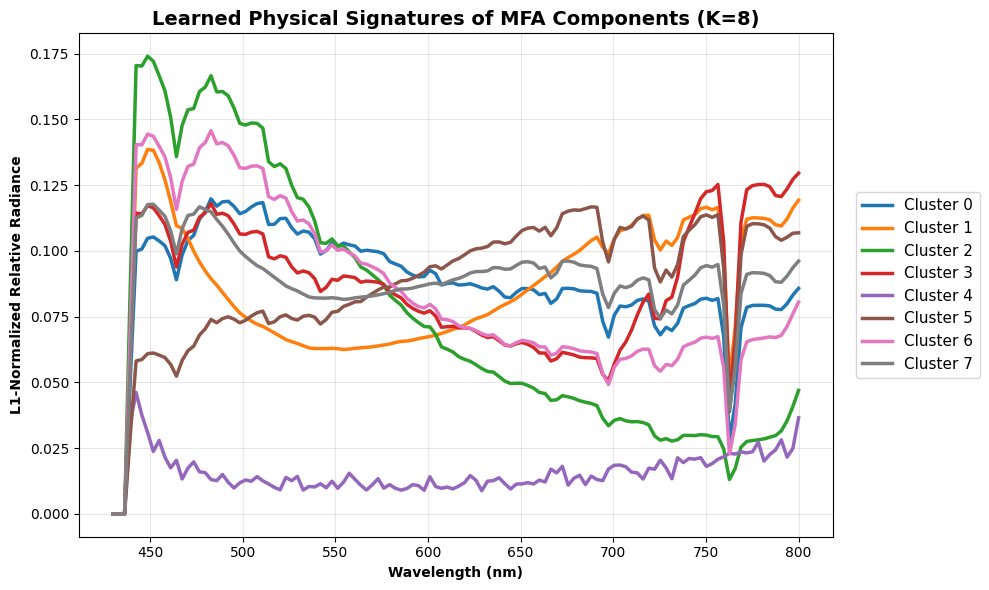

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Generate the correct wavelength X-axis for HYPSO-1
# HYPSO-1 has 120 usable binned bands ranging from roughly 430 nm to 800 nm.
# We create a linear array to represent the physical wavelengths (in nanometers).
wavelengths_nm = np.linspace(430, 800, 120) 

# Grab the discrete 'tab10' colormap (tab10 is generally more distinct than tab20 for K=8)
cmap = plt.get_cmap('tab10')

# Extract params
K = mfa_model.K
q = mfa_model.q
n_features = mfa_model.D

print(f"Model Parameters: K={K}, q={q}, n_features={n_features}")

# Extract means. 
# Because you used L1 Normalization, these are essentially "probability distributions" of light.
physical_means = mfa_model.mu.cpu().detach().numpy() 
        
# Create the figure
fig, ax = plt.subplots(figsize=(10, 6))

for k in range(K):
    # Modulo 10 ensures we don't get an index error if K > 10
    color_idx = k % 10 
    
    # Plot against the physical wavelengths, not just abstract band indices
    ax.plot(wavelengths_nm, physical_means[k], 
            label=f'Cluster {k}', 
            color=cmap.colors[color_idx], 
            linewidth=2.5)
    
ax.set_title(f"Learned Physical Signatures of MFA Components (K={K})", fontweight='bold', fontsize=14)
ax.set_xlabel("Wavelength (nm)", fontweight='bold')

# Since you used L1 Normalization, the Y-axis is no longer absolute reflectance/radiance.
ax.set_ylabel("L1-Normalized Relative Radiance", fontweight='bold') 

ax.grid(True, alpha=0.3)
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=11) 

plt.tight_layout()
plt.show()

Success-measure for mu-plot: 
-

In [15]:
test_data_dir = glob.glob(f'data/testing_{data_product.value}/*.nc')
print(f"Found {len(test_data_dir)} files.")

target_total_samples = 15000

test_data_list = get_data(test_data_dir, data_product.value, target_total_samples)

test_data = torch.from_numpy(test_data_list).float().to(device)

# 2. Apply L1 Normalization (Sum of absolute values = 1)
# This turns the data into "relative radiance" (shape only, ignoring shadows)
X_raw = test_data.clone().detach().to(dtype=torch.float32, device=device)
if Train_MFA_on_L1Normalized:
    print("Applying L1 Normalization to data for interpretability")
    l1_norms = torch.linalg.norm(X_raw, ord=1, dim=1, keepdim=True)
    epsilon = 1e-8
    X_processed = X_raw / (l1_norms + epsilon)
else:
    print("Using raw data without normalization")
    X_processed = X_raw

Found 14 files.
Aiming to extract ~1071 pixels per file from 14 files to reach a total of ~15000 samples.
1/14 | File: data/testing_l1b\a_mwanza_2022-07-21T07-43-03Z-l1b.nc | Extracted 1071 pixels.
2/14 | File: data/testing_l1b\caspiansea2_2024-07-07T06-58-07Z-l1b.nc | Extracted 1071 pixels.
3/14 | File: data/testing_l1b\durban_2023-06-13T07-33-54Z-l1b.nc | Extracted 1071 pixels.
4/14 | File: data/testing_l1b\falklands_2022-12-02T12-27-07Z-l1b.nc | Extracted 1071 pixels.
5/14 | File: data/testing_l1b\garrylake_2025-02-03T17-29-18Z-l1b.nc | Extracted 1071 pixels.
6/14 | File: data/testing_l1b\gobabeb_2024-03-14T09-14-22Z-l1b.nc | Extracted 1071 pixels.
7/14 | File: data/testing_l1b\gulfofcampeche_2024-05-17T15-49-37Z-l1b.nc | Extracted 1071 pixels.
8/14 | File: data/testing_l1b\jiaozhouBayBridge_2022-11-20T01-55-00Z-l1b.nc | Extracted 1071 pixels.
9/14 | File: data/testing_l1b\lacrau_2025-01-17T09-40-10Z-l1b.nc | Extracted 1071 pixels.
10/14 | File: data/testing_l1b\lakevolta_2023-01-19

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def plot_latent_interpretability(mfa_model, X_raw, X_processed, cluster_ids, target_cluster=0):
    """
    Test C: Proves that the latent factors capture physical illumination.
    Loops through all q factors for a specific cluster and plots them against raw brightness.
    """
    print(f"--- Running Test C for Cluster {target_cluster} ---")
    
    # 1. Isolate the pixels belonging to the target cluster
    mask = (cluster_ids == target_cluster)
    X_raw_k = X_raw[mask]
    X_processed_k = X_processed[mask]
    
    if len(X_raw_k) == 0:
        print(f"Cluster {target_cluster} has no pixels!")
        return
    else: 
        print(f"Cluster {target_cluster} has {len(X_raw_k)} pixels for analysis.")

    # 2. Calculate the "Ground Truth" Physical Brightness (L2 Norm of the RAW L1b data)
    # This represents how brightly lit the pixel was before we L1-normalized it.
    brightness = torch.linalg.norm(X_raw_k, dim=1).cpu().numpy()
    
    # 3. Extract the Latent Factors (Z) for these pixels
    # Mathematically: Z = (X - mu) * pseudo_inverse(Lambda)
    with torch.no_grad():
        mu_k = mfa_model.mu[target_cluster]
        Lambda_k = mfa_model.Lambda[target_cluster] # Shape: (D, q)
        
        # Center the data
        X_centered = X_processed_k - mu_k
        
        # Project onto the latent space using the pseudo-inverse
        Lambda_pinv = torch.linalg.pinv(Lambda_k) # Shape: (q, D)
        Z = (X_centered @ Lambda_pinv.T).cpu().numpy() # Shape: (N, q)
        
    # 4. Plot all factors (q) for this cluster
    q = mfa_model.q
    fig, axes = plt.subplots(1, q, figsize=(4 * q, 5), sharey=True)
    
    if q == 1:
        axes = [axes] # Ensure iterable
        
    for j in range(q):
        z_j = Z[:, j]
        
        # Calculate correlation
        corr, _ = pearsonr(brightness, z_j)
        
        # Scatter plot
        axes[j].scatter(brightness, z_j, alpha=0.2, s=2, color='teal')
        axes[j].set_title(f"Factor z_{j+1}\nCorrelation: {corr:.3f}", fontweight='bold')
        axes[j].set_xlabel("Raw Pixel Brightness (L2 Norm)")
        axes[j].grid(True, alpha=0.3)
        
        # Add a trendline
        m, b = np.polyfit(brightness, z_j, 1)
        axes[j].plot(brightness, m*brightness + b, color='red', linewidth=2)

    axes[0].set_ylabel("Latent Factor Value", fontweight='bold')
    plt.suptitle(f"Latent Space vs. Physical Illumination (Cluster {target_cluster})", fontsize=16, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.show()

# Run the test! (Assuming you have X_raw, X_processed, and cluster_ids from your notebook)
# You can change target_cluster to test different materials (e.g., Water, Forest)

for cluster in range(mfa_model.K):
    plot_latent_interpretability(mfa_model, X_raw, X_processed, cluster_ids, target_cluster=cluster)

NameError: name 'X' is not defined

--- Running Test D: Outlier Rejection Threshold ---


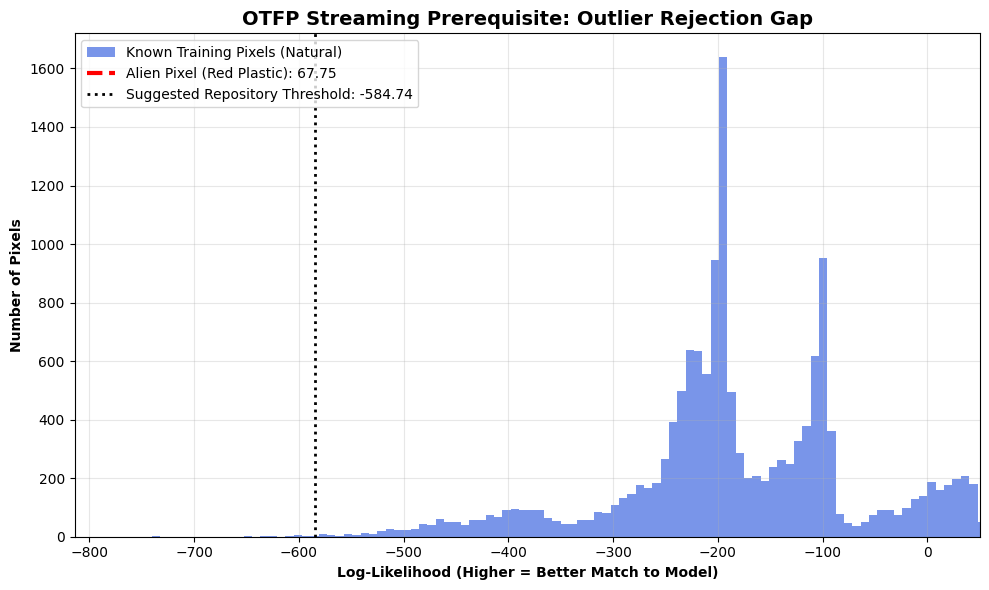

Normal Pixels Mean LL: -183.08
Alien Pixel LL:        67.75
Absolute Gap:          807.74 log-likelihood units


In [ ]:
def test_outlier_rejection(mfa_model, X_processed):
    """
    Test D: Proves the model can confidently reject alien pixels for the OTFP streaming logic.
    """
    print("--- Running Test D: Outlier Rejection Threshold ---")
    
    with torch.no_grad():
        # 1. Get the Log-Likelihood of all normal training pixels
        _, ll_normal = mfa_model.e_step(X_processed)
        ll_normal_np = ll_normal.cpu().numpy()
        
        # 2. Create an "Alien" Pixel (e.g., A piece of bright red plastic)
        # We simulate this by creating a massive spike in the red wavelengths (~band 80)
        D = mfa_model.D
        alien_raw = torch.ones(1, D, device=device) * 0.1 # Baseline noise
        alien_raw[0, 75:85] = 5.0 # Massive red spike
        
        # We MUST apply the same L1-Normalization preprocessing!
        alien_processed = alien_raw / torch.linalg.norm(alien_raw, ord=1, dim=1, keepdim=True)
        
        # 3. Get the Log-Likelihood of the Alien Pixel
        _, ll_alien = mfa_model.e_step(alien_processed)
        ll_alien_np = ll_alien.item()
        
    # 4. Plot the Distributions
    plt.figure(figsize=(10, 6))
    
    # Plot histogram of normal pixels
    plt.hist(ll_normal_np, bins=100, color='royalblue', alpha=0.7, label='Known Training Pixels (Natural)')
    
    # Plot the alien pixel as a vertical red line
    plt.axvline(x=ll_alien_np, color='red', linestyle='--', linewidth=3, label=f'Alien Pixel (Red Plastic): {ll_alien_np:.2f}')
    
    # Calculate and plot the threshold (e.g., 99.9th percentile of normal data)
    threshold = np.percentile(ll_normal_np, 0.1) # Bottom 0.1% of normal data
    plt.axvline(x=threshold, color='black', linestyle=':', linewidth=2, label=f'Suggested Repository Threshold: {threshold:.2f}')
    
    plt.title("OTFP Streaming Prerequisite: Outlier Rejection Gap", fontweight='bold', fontsize=14)
    plt.xlabel("Log-Likelihood (Higher = Better Match to Model)", fontweight='bold')
    plt.ylabel("Number of Pixels", fontweight='bold')
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # Zoom the x-axis to show the gap properly
    min_x = min(ll_alien_np * 1.1, np.min(ll_normal_np) * 1.1)
    max_x = np.max(ll_normal_np) * 0.9
    plt.xlim(min_x, max_x)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Normal Pixels Mean LL: {np.mean(ll_normal_np):.2f}")
    print(f"Alien Pixel LL:        {ll_alien_np:.2f}")
    print(f"Absolute Gap:          {abs(np.min(ll_normal_np) - ll_alien_np):.2f} log-likelihood units")

# Run the test!
test_outlier_rejection(mfa_model, X)